# F1 Data Management Project v1.1

**Research Question:** How did ground effect regulations and budget cap change car performance in Formula 1?

**Data Sources:**
1. Jolpica API - Qualifying results (API)
2. ENTITY RESOLUTION - Team Name Mapping
3. OpenAI GPT 5mini  - Regulations history (Scraping/data retrival)
4. FIA ATR - Wind tunnel/CFD allocations (API-derived)
5. WDC/WCC Championship Winners (Jolpica API)
6. SQL STORAGE (SQLite) 


**Period:** 2017-2025 (Pre and Post 2022 regulations)

In [18]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

---
## 1. Data Acquisition - Source 1: Qualifying Results (Jolpica API)

In [48]:
def get_all_qualifying(year):
    """Get ALL qualifying results for a year with pagination from Jolpica API"""
    all_results = []
    offset = 0
    limit = 100
    
    while True:
        url = f"https://api.jolpi.ca/ergast/f1/{year}/qualifying.json?limit={limit}&offset={offset}"
        response = requests.get(url)
        data = response.json()
        
        races = data['MRData']['RaceTable']['Races']
        if not races:
            break
            
        for race in races:
            for result in race['QualifyingResults']:
                best_time = result.get('Q3') or result.get('Q2') or result.get('Q1')
                all_results.append({
                    'Year': int(year),
                    'Round': int(race['round']),
                    'GrandPrix': race['raceName'],
                    'Circuit': race['Circuit']['circuitName'],
                    'CircuitID': race['Circuit']['circuitId'],
                    'Position': int(result['position']),
                    'Driver': result['Driver'].get('code', result['Driver']['familyName'][:3].upper()),
                    'DriverName': f"{result['Driver']['givenName']} {result['Driver']['familyName']}",
                    'Team': result['Constructor']['name'],
                    'Q1': result.get('Q1'),
                    'Q2': result.get('Q2'),
                    'Q3': result.get('Q3'),
                    'BestTime': best_time
                })
        
        offset += limit
        total = int(data['MRData']['total'])
        if offset >= total:
            break
        time.sleep(0.3)
    
    return all_results

# Fetch all years
all_data = []
for year in range(2017, 2026):
    results = get_all_qualifying(year)
    all_data.extend(results)
    races_count = len(set(r['Round'] for r in results))
    print(f" {year}: {races_count} races, {len(results)} results")
    time.sleep(0.5)

df_qualifying = pd.DataFrame(all_data)
print(f"\n{'='*50}")
print(f"Total: {len(df_qualifying)} qualifying results")

 2017: 20 races, 398 results
 2018: 21 races, 420 results
 2019: 21 races, 418 results
 2020: 17 races, 340 results
 2021: 22 races, 439 results
 2022: 22 races, 440 results
 2023: 22 races, 440 results
 2024: 24 races, 479 results
 2025: 24 races, 479 results

Total: 3853 qualifying results


In [49]:
df_qualifying

,Year,Round,GrandPrix,Circuit,CircuitID,Position,Driver,DriverName,Team,Q1,Q2,Q3,BestTime
0,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,1,HAM,Lewis Hamilton,Mercedes,1:24.191,1:23.251,1:22.188,1:22.188
1,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,2,VET,Sebastian Vettel,Ferrari,1:25.210,1:23.401,1:22.456,1:22.456
2,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,3,BOT,Valtteri Bottas,Mercedes,1:24.514,1:23.215,1:22.481,1:22.481
3,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,4,RAI,Kimi Räikkönen,Ferrari,1:24.352,1:23.376,1:23.033,1:23.033
4,2017,1,Australian Grand Prix,Albert Park Grand Prix Circuit,albert_park,5,VER,Max Verstappen,Red Bull,1:24.482,1:24.092,1:23.485,1:23.485
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3848,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,16,HAM,Lewis Hamilton,Ferrari,1:23.394,None,None,1:23.394
3849,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,17,ALB,Alexander Albon,Williams,1:23.416,None,None,1:23.416
3850,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,18,HUL,Nico Hülkenberg,Sauber,1:23.450,None,None,1:23.450
3851,2025,24,Abu Dhabi Grand Prix,Yas Marina Circuit,yas_marina,19,GAS,Pierre Gasly,Alpine F1 Team,1:23.468,None,None,1:23.468


## 2. ENTITY RESOLUTION - Team Name Mapping


In [50]:

TEAM_ENTITY_MAP = {
    # Red Bull B-Team (Toro Rosso → AlphaTauri → RB)
    'Toro Rosso': 'RB F1 Team',
    'Scuderia Toro Rosso': 'RB F1 Team',
    'AlphaTauri': 'RB F1 Team',
    'Scuderia AlphaTauri': 'RB F1 Team',
    'RB F1 Team': 'RB F1 Team',
    
    # Sauber (Sauber → Alfa Romeo → Sauber)
    'Sauber': 'Sauber',
    'Alfa Romeo Sauber F1 Team': 'Sauber',
    'Alfa Romeo': 'Sauber',
    'Alfa Romeo Racing': 'Sauber',
    
    # Force India → Racing Point → Aston Martin
    'Force India': 'Aston Martin',
    'Racing Point': 'Aston Martin',
    'Aston Martin': 'Aston Martin',
    
    # Renault → Alpine
    'Renault': 'Alpine F1 Team',
    'Alpine F1 Team': 'Alpine F1 Team',
    
    # Teams che non cambiano (passthrough)
    'Mercedes': 'Mercedes',
    'Red Bull': 'Red Bull',
    'Ferrari': 'Ferrari',
    'McLaren': 'McLaren',
    'Williams': 'Williams',
    'Haas F1 Team': 'Haas F1 Team',
    
    # Defunct teams (2017 only)
    'Lotus F1': 'Lotus F1',
    'Manor Marussia': 'Manor Marussia',
}

def resolve_team_entity(team_name):
    """Resolve team name to canonical entity"""
    return TEAM_ENTITY_MAP.get(team_name, team_name)

# Apply entity resolution
df_qualifying['Team_Entity'] = df_qualifying['Team'].apply(resolve_team_entity)

# Verify counts
print("Entity Resolution Applied:")
print(df_qualifying.groupby(['Team', 'Team_Entity']).size().reset_index(name='count'))

Entity Resolution Applied:
              Team     Team_Entity  count
0       Alfa Romeo          Sauber    207
1       AlphaTauri      RB F1 Team    166
2   Alpine F1 Team  Alpine F1 Team    228
3     Aston Martin    Aston Martin    228
4          Ferrari         Ferrari    386
5      Force India    Aston Martin     82
6     Haas F1 Team    Haas F1 Team    385
7          McLaren         McLaren    386
8         Mercedes        Mercedes    386
9       RB F1 Team      RB F1 Team     96
10    Racing Point    Aston Martin     76
11        Red Bull        Red Bull    386
12         Renault  Alpine F1 Team    157
13          Sauber          Sauber    177
14      Toro Rosso      RB F1 Team    122
15        Williams        Williams    385


## 3. LLM regulations extraction

In [ ]:
import os
from getpass import getpass

# Chiede la chiave solo se non è già impostata (chiavi ingiustamente non rubate)
if not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass("Inserisci OpenAI API Key: ")

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

In [10]:
# ===================================================================
# F1 REGULATION EXTRACTION via OpenAI API
# ===================================================================
import openai
import json
import time
import pandas as pd
import numpy as np
import os
from getpass import getpass

# OpenAI API Configuration
if not os.environ.get('OPENAI_API_KEY'):
    os.environ['OPENAI_API_KEY'] = getpass("Inserisci OpenAI API Key: ")

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
OPENAI_MODEL = 'gpt-5-mini-2025-08-07'
openai.api_key = OPENAI_API_KEY

def get_regulations_from_openai(year):
    '''Use OpenAI API to extract F1 regulation changes for a given year'''
    prompt = f'''For {year} F1 season, list main regulation changes.
Return JSON array: [{{"Year": {year}, "Type": "Aero/Financial/Safety/Engine", "Description": "...", "Impact": "Major/Minor/Revolutionary", "Source": "FIA {year}"}}].
Only JSON.'''
    
    response = openai.chat.completions.create(
        model=OPENAI_MODEL,
        messages=[{'role': 'user', 'content': prompt}],
    )
    return response.choices[0].message.content

# Extract regulations for each year using OpenAI API
print(f'Extracting F1 regulations via OpenAI API ({OPENAI_MODEL})...')
print('='*60)

all_regulations = []
for year in range(2017, 2026):  # Iterazione diretta sugli anni!
    print(f'{year}...', end=' ')
    try:
        result = get_regulations_from_openai(year)
        result = result.strip()
        if result.startswith('```json'): result = result[7:]
        if result.startswith('```'): result = result[3:]
        if result.endswith('```'): result = result[:-3]
        
        regs = json.loads(result.strip())
        all_regulations.extend(regs)
        print(f'{len(regs)} regulations extracted')
    except Exception as e:
        print(f'Error: {e}')
    
    time.sleep(1)

# Create DataFrame
df_regulations = pd.DataFrame(all_regulations)
df_regulations['Era'] = np.where(df_regulations['Year'] < 2022, 'Pre-2022', 'Post-2022')
df_regulations['Extraction_Method'] = f'OpenAI API ({OPENAI_MODEL})'

# Save to CSV
df_regulations.to_csv('f1_regulations_openai.csv', index=False)

print('='*60)
print(f'Regulations dataset: {len(df_regulations)} entries extracted via {OPENAI_MODEL}')
df_regulations

Extracting F1 regulations via OpenAI API (gpt-5-mini-2025-08-07)...
2017... 6 regulations extracted
2018... 5 regulations extracted
2019... 4 regulations extracted
2020... 4 regulations extracted
2021... 4 regulations extracted
2022... 8 regulations extracted
2023... 7 regulations extracted
2024... 4 regulations extracted
2025... 4 regulations extracted
Regulations dataset: 46 entries extracted via gpt-5-mini-2025-08-07


,Year,Type,Description,Impact,Source,Era,Extraction_Method
0,2017,Aero,Comprehensive aerodynamic overhaul for 2017: c...,Revolutionary,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
1,2017,Aero,Tyre and wheel regulation changes: significant...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
2,2017,Aero,Car dimensional and mass adjustments: overall ...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
3,2017,Engine,Power unit rules largely carried over from pri...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
4,2017,Safety,Incremental safety rule updates: ongoing tight...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
5,2017,Financial,No new cost-cap or major financial redistribut...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
6,2018,Safety,Mandatory introduction of the 'halo' cockpit p...,Major,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
7,2018,Safety,Revised cockpit and chassis test procedures an...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
8,2018,Engine,Continuation and enforcement of power unit dev...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
9,2018,Aero,Technical clarifications and targeted adjustme...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)


LOAD REGULATIONS EXTRACTED via OpenAI API (gpt-5-mini-2025-08-07)

In [12]:
# Model: OpenAI API (gpt-5-mini-2025-08-07)

df_regulations = pd.read_csv('f1_regulations_openai.csv')
df_regulations['Era'] = df_regulations['Year'].apply(lambda x: 'Pre-2022' if x < 2022 else 'Post-2022')

print(f"Loaded {len(df_regulations)} regulations from OpenAI extraction")
df_regulations

Loaded 46 regulations from OpenAI extraction


,Year,Type,Description,Impact,Source,Era,Extraction_Method
0,2017,Aero,Comprehensive aerodynamic overhaul for 2017: c...,Revolutionary,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
1,2017,Aero,Tyre and wheel regulation changes: significant...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
2,2017,Aero,Car dimensional and mass adjustments: overall ...,Major,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
3,2017,Engine,Power unit rules largely carried over from pri...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
4,2017,Safety,Incremental safety rule updates: ongoing tight...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
5,2017,Financial,No new cost-cap or major financial redistribut...,Minor,FIA 2017,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
6,2018,Safety,Mandatory introduction of the 'halo' cockpit p...,Major,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
7,2018,Safety,Revised cockpit and chassis test procedures an...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
8,2018,Engine,Continuation and enforcement of power unit dev...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)
9,2018,Aero,Technical clarifications and targeted adjustme...,Minor,FIA 2018,Pre-2022,OpenAI API (gpt-5-mini-2025-08-07)



## 4. ATR Allocations (Jolpica API)

In [35]:
# ATR allocation percentages (based on previous year's position)
# Source: FIA Aerodynamic Testing Regulations
atr_percentages = {
    1: 0.70, 2: 0.75, 3: 0.80, 4: 0.85, 5: 0.90,
    6: 0.95, 7: 1.00, 8: 1.05, 9: 1.10, 10: 1.15
}

BASELINE_WT_RUNS = 320
BASELINE_CFD_ITEMS = 2000
ATR_PERIODS_PER_YEAR = 6

def get_constructor_standings(year):
    """Get constructor standings from Jolpica API"""
    url = f"https://api.jolpi.ca/ergast/f1/{year}/constructorStandings.json"
    response = requests.get(url)
    data = response.json()
    standings = data['MRData']['StandingsTable']['StandingsLists']
    if not standings:
        return None
    return standings[0]['ConstructorStandings']

# Build ATR database (2022-2025)
atr_data = []
for year in range(2022, 2026):
    prev_standings = get_constructor_standings(year - 1)
    
    if prev_standings is None:
        continue
    
    for standing in prev_standings:
        position = int(standing['position'])
        team = standing['Constructor']['name']
        
        pct = atr_percentages.get(position, 1.0)
        wt_runs_per_period = int(BASELINE_WT_RUNS * pct)
        cfd_per_period = int(BASELINE_CFD_ITEMS * pct)
        
        atr_data.append({
            'Year': year,
            'Team': team,
            'PreviousPosition': position,
            'ATR_Percentage': pct * 100,
            'WT_RunsPerPeriod': wt_runs_per_period,
            'WT_RunsAnnual': wt_runs_per_period * ATR_PERIODS_PER_YEAR,
            'CFD_ItemsPerPeriod': cfd_per_period,
            'CFD_ItemsAnnual': cfd_per_period * ATR_PERIODS_PER_YEAR,
            'Source': 'Jolpica API + FIA ATR'
        })
    
    print(f" {year} ATR allocations calculated from API")
    time.sleep(0.3)

df_atr = pd.DataFrame(atr_data)
print(f"\n ATR dataset: {len(df_atr)} entries from Jolpica API")

 2022 ATR allocations calculated from API
 2023 ATR allocations calculated from API
 2024 ATR allocations calculated from API
 2025 ATR allocations calculated from API

 ATR dataset: 40 entries from Jolpica API


In [40]:
df_atr

,Year,Team,PreviousPosition,ATR_Percentage,WT_RunsPerPeriod,WT_RunsAnnual,CFD_ItemsPerPeriod,CFD_ItemsAnnual,Source
0,2022,Mercedes,1,70.0,224,1344,1400,8400,Jolpica API + FIA ATR
1,2022,Red Bull,2,75.0,240,1440,1500,9000,Jolpica API + FIA ATR
2,2022,Ferrari,3,80.0,256,1536,1600,9600,Jolpica API + FIA ATR
3,2022,McLaren,4,85.0,272,1632,1700,10200,Jolpica API + FIA ATR
4,2022,Alpine F1 Team,5,90.0,288,1728,1800,10800,Jolpica API + FIA ATR
5,2022,AlphaTauri,6,95.0,304,1824,1900,11400,Jolpica API + FIA ATR
6,2022,Aston Martin,7,100.0,320,1920,2000,12000,Jolpica API + FIA ATR
7,2022,Williams,8,105.0,336,2016,2100,12600,Jolpica API + FIA ATR
8,2022,Alfa Romeo,9,110.0,352,2112,2200,13200,Jolpica API + FIA ATR
9,2022,Haas F1 Team,10,115.0,368,2208,2300,13800,Jolpica API + FIA ATR



## 5. Data Preparation

In [39]:
def time_to_seconds(time_str):
    """Convert qualifying time string (M:SS.mmm) to seconds"""
    if pd.isna(time_str) or time_str is None:
        return None
    try:
        parts = time_str.split(':')
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes * 60 + seconds
    except:
        return None

# Apply conversion
df_qualifying['BestTime_Seconds'] = df_qualifying['BestTime'].apply(time_to_seconds)

# Get pole time per race
df_qualifying['PoleTime'] = df_qualifying.groupby(['Year', 'Round'])['BestTime_Seconds'].transform('min')

# Calculate gap to pole
df_qualifying['GapToPole'] = df_qualifying['BestTime_Seconds'] - df_qualifying['PoleTime']

# Add era column
df_qualifying['Era'] = df_qualifying['Year'].apply(lambda x: 'Pre-2022' if x < 2022 else 'Post-2022')

print(" Time conversion and gap calculation complete")

 Time conversion and gap calculation complete



## 6. Data Integration

In [41]:
# Create regulations summary per year
reg_summary = df_regulations.groupby('Year').agg(
    RegulationChanges=('Description', 'count'),
    MajorChanges=('Impact', lambda x: (x.isin(['Major', 'Revolutionary'])).sum()),
    HasRevolutionary=('Impact', lambda x: 'Yes' if 'Revolutionary' in x.values else 'No')
).reset_index()

# Merge regulations summary with qualifying data
df_qualifying = df_qualifying.merge(reg_summary, on='Year', how='left')

# Merge ATR allocations with qualifying data
df_qualifying = df_qualifying.merge(
    df_atr[['Year', 'Team', 'ATR_Percentage', 'WT_RunsAnnual', 'CFD_ItemsAnnual']], 
    on=['Year', 'Team'], 
    how='left'
)

print(f" Integrated dataset: {len(df_qualifying)} rows, {len(df_qualifying.columns)} columns")
print(f"\nData Sources Integrated:")
print("  1. Jolpica API - Qualifying results")
print("  2. Wikipedia API - Season summaries (scraped)")
print("  3. Jolpica API - ATR allocations (derived)")

 Integrated dataset: 4684 rows, 29 columns

Data Sources Integrated:
  1. Jolpica API - Qualifying results
  2. Wikipedia API - Season summaries (scraped)
  3. Jolpica API - ATR allocations (derived)



## 7. Data Quality Assessment

In [42]:
def calculate_data_quality(df, name, exclude_cols=None):
    """Calculate data quality metrics, optionally excluding columns from completeness"""
    
    if exclude_cols:
        df_check = df.drop(columns=exclude_cols, errors='ignore')
    else:
        df_check = df
    
    total_cells = df_check.size
    null_cells = df_check.isnull().sum().sum()
    completeness = (1 - null_cells / total_cells) * 100
    
    col_completeness = (1 - df.isnull().sum() / len(df)) * 100
    
    print(f"\n=== Data Quality Report: {name} ===")
    print(f"Total Records: {len(df)}")
    print(f"Total Columns: {len(df.columns)}")
    if exclude_cols:
        print(f"Excluded from completeness: {exclude_cols} (structural nulls)")
    print(f"Overall Completeness: {completeness:.2f}%")
    print(f"\nPer-column Completeness:")
    for col, comp in col_completeness.items():
        status = " (expected)" if exclude_cols and col in exclude_cols else ""
        print(f"  {col}: {comp:.1f}%{status}")
    
    return {
        'Dataset': name,
        'Records': len(df),
        'Columns': len(df.columns),
        'Completeness': completeness
    }

quality_results = []
# Escludi Q2/Q3 - i null sono strutturali (solo 15 e 10 piloti rispettivamente)
quality_results.append(calculate_data_quality(df_qualifying, 'Qualifying', exclude_cols=['Q2', 'Q3']))
quality_results.append(calculate_data_quality(df_regulations, 'Regulations'))
quality_results.append(calculate_data_quality(df_atr, 'ATR Allocations'))

df_quality = pd.DataFrame(quality_results)
print(f"\n=== Summary ===")
df_quality


=== Data Quality Report: Qualifying ===
Total Records: 4684
Total Columns: 29
Excluded from completeness: ['Q2', 'Q3'] (structural nulls)
Overall Completeness: 81.97%

Per-column Completeness:
  Year: 100.0%
  Round: 100.0%
  GrandPrix: 100.0%
  Circuit: 100.0%
  CircuitID: 100.0%
  Position: 100.0%
  Driver: 100.0%
  DriverName: 100.0%
  Team: 100.0%
  Q1: 100.0%
  Q2: 74.0% (expected)
  Q3: 48.7% (expected)
  BestTime: 100.0%
  RegulationChanges_x: 82.3%
  MajorChanges_x: 82.3%
  HasRevolutionary_x: 82.3%
  ATR_Percentage_x: 37.2%
  WT_RunsAnnual_x: 37.2%
  CFD_ItemsAnnual_x: 37.2%
  BestTime_Seconds: 98.5%
  PoleTime: 99.6%
  GapToPole: 98.5%
  Era: 100.0%
  RegulationChanges_y: 82.3%
  MajorChanges_y: 82.3%
  HasRevolutionary_y: 82.3%
  ATR_Percentage_y: 37.2%
  WT_RunsAnnual_y: 37.2%
  CFD_ItemsAnnual_y: 37.2%

=== Data Quality Report: Regulations ===
Total Records: 46
Total Columns: 7
Overall Completeness: 100.00%

Per-column Completeness:
  Year: 100.0%
  Type: 100.0%
  Descrip

,Dataset,Records,Columns,Completeness
0,Qualifying,4684,29,81.974887
1,Regulations,46,7,100.000000
2,ATR Allocations,40,9,100.000000



## 8. Analysis - Field Spread by Era

In [43]:
# Field spread: gap between P1 and P10 per race
top10 = df_qualifying[df_qualifying['Position'] <= 10]
field_spread = top10.groupby(['Year', 'Round', 'GrandPrix', 'Era']).agg(
    P1_Time=('BestTime_Seconds', 'min'),
    P10_Time=('BestTime_Seconds', 'max'),
    Spread=('GapToPole', 'max')
).reset_index()

print("Average P1-P10 spread by era:")
era_spread = field_spread.groupby('Era')['Spread'].mean()
print(era_spread)

# Yearly trend
yearly_spread = field_spread.groupby('Year')['Spread'].mean()
print("\nYearly spread:")
print(yearly_spread)

Average P1-P10 spread by era:
Era
Post-2022    2.150098
Pre-2022     2.747364
Name: Spread, dtype: float64

Yearly spread:
Year
2015    2.703737
2016    2.907048
2017    2.291750
2018    4.401381
2019    2.028762
2020    2.111250
2021    2.616545
2022    3.667318
2023    1.980727
2024    1.952417
2025    1.112250
Name: Spread, dtype: float64


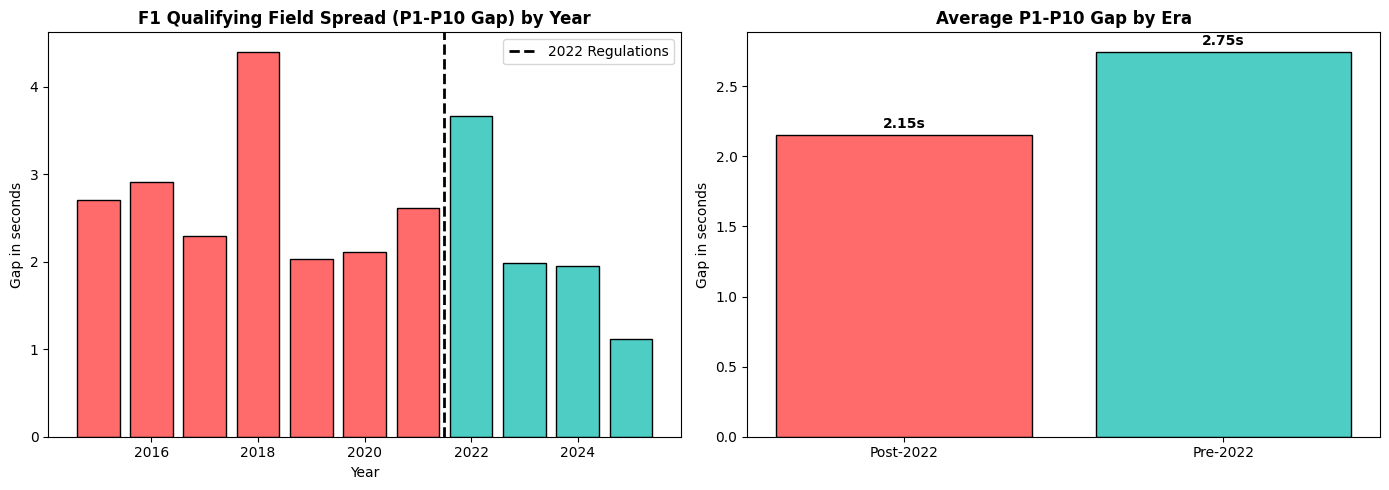

In [44]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Field Spread by Year
years = yearly_spread.index
spreads = yearly_spread.values
colors = ['#FF6B6B' if y < 2022 else '#4ECDC4' for y in years]

axes[0].bar(years, spreads, color=colors, edgecolor='black')
axes[0].axvline(x=2021.5, color='black', linestyle='--', linewidth=2, label='2022 Regulations')
axes[0].set_title('F1 Qualifying Field Spread (P1-P10 Gap) by Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Gap in seconds')
axes[0].set_xlabel('Year')
axes[0].legend()

# Plot 2: Era Comparison
axes[1].bar(era_spread.index, era_spread.values, color=['#FF6B6B', '#4ECDC4'], edgecolor='black')
axes[1].set_title('Average P1-P10 Gap by Era', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Gap in seconds')
for i, (era, val) in enumerate(era_spread.items()):
    axes[1].text(i, val + 0.05, f'{val:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('f1_field_spread_analysis.png', dpi=150)
plt.show()


## 9. Storage & Export

In [45]:
# Save all datasets
df_qualifying.to_csv('f1_qualifying_complete.csv', index=False)
df_qualifying.to_parquet('f1_qualifying_complete.parquet', index=False)

df_regulations.to_csv('f1_regulations_changes.csv', index=False)
df_atr.to_csv('f1_atr_allocations.csv', index=False)

field_spread.to_csv('f1_field_spread.csv', index=False)
df_quality.to_csv('f1_data_quality_report.csv', index=False)

print(" All datasets saved!")
print(f"\nFiles created:")
print(f"  - f1_qualifying_complete.csv ({len(df_qualifying)} rows)")
print(f"  - f1_regulations_changes.csv ({len(df_regulations)} rows)")
print(f"  - f1_atr_allocations.csv ({len(df_atr)} rows)")
print(f"  - f1_field_spread.csv ({len(field_spread)} rows)")
print(f"  - f1_data_quality_report.csv")
print(f"  - f1_field_spread_analysis.png")

 All datasets saved!

Files created:
  - f1_qualifying_complete.csv (4684 rows)
  - f1_regulations_changes.csv (46 rows)
  - f1_atr_allocations.csv (40 rows)
  - f1_field_spread.csv (233 rows)
  - f1_data_quality_report.csv
  - f1_field_spread_analysis.png


# Source 4: WDC/WCC Championship Winners (Jolpica API)

In [46]:

def get_driver_standings_winner(year):
    """Get WDC winner from Jolpica API"""
    url = f"https://api.jolpi.ca/ergast/f1/{year}/driverstandings/1.json"
    response = requests.get(url)
    data = response.json()['MRData']['StandingsTable']['StandingsLists']
    if data and data[0].get('DriverStandings'):
        ds = data[0]['DriverStandings'][0]
        return {
            'name': f"{ds['Driver']['givenName']} {ds['Driver']['familyName']}",
            'team': ds['Constructors'][0]['name'] if ds.get('Constructors') else None
        }
    return None

def get_constructor_standings_winner(year):
    """Get WCC winner from Jolpica API"""
    url = f"https://api.jolpi.ca/ergast/f1/{year}/constructorstandings/1.json"
    response = requests.get(url)
    data = response.json()['MRData']['StandingsTable']['StandingsLists']
    if data and data[0].get('ConstructorStandings'):
        return data[0]['ConstructorStandings'][0]['Constructor']['name']
    return None

# Fetch WDC/WCC winners for all seasons
print("Fetching WDC/WCC winners...")
championships_data = []
for year in range(2017, 2026):
    wdc = get_driver_standings_winner(year)
    wcc = get_constructor_standings_winner(year)
    
    championships_data.append({
        'Year': year,
        'WDC_Driver': wdc['name'] if wdc else None,
        'WDC_Team': wdc['team'] if wdc else None,
        'WCC_Team': wcc
    })
    print(f" {year}: WDC={wdc['name'] if wdc else 'N/A'}, WCC={wcc}")
    time.sleep(0.3)

df_championships = pd.DataFrame(championships_data)
print(f"\n Championships dataset: {len(df_championships)} seasons")
df_championships


Fetching WDC/WCC winners...
 2017: WDC=Lewis Hamilton, WCC=Mercedes
 2018: WDC=Lewis Hamilton, WCC=Mercedes
 2019: WDC=Lewis Hamilton, WCC=Mercedes
 2020: WDC=Lewis Hamilton, WCC=Mercedes
 2021: WDC=Max Verstappen, WCC=Mercedes
 2022: WDC=Max Verstappen, WCC=Red Bull
 2023: WDC=Max Verstappen, WCC=Red Bull
 2024: WDC=Max Verstappen, WCC=McLaren
 2025: WDC=Lando Norris, WCC=McLaren

 Championships dataset: 9 seasons


,Year,WDC_Driver,WDC_Team,WCC_Team
0,2017,Lewis Hamilton,Mercedes,Mercedes
1,2018,Lewis Hamilton,Mercedes,Mercedes
2,2019,Lewis Hamilton,Mercedes,Mercedes
3,2020,Lewis Hamilton,Mercedes,Mercedes
4,2021,Max Verstappen,Red Bull,Mercedes
5,2022,Max Verstappen,Red Bull,Red Bull
6,2023,Max Verstappen,Red Bull,Red Bull
7,2024,Max Verstappen,Red Bull,McLaren
8,2025,Lando Norris,McLaren,McLaren


## SQL STORAGE (SQLite) 

In [47]:

import sqlite3
import pandas as pd
import os

# Verifica DataFrame
try:
    _ = df_qualifying
    _ = df_atr  
    _ = df_regulations
    _ = df_championships  # Nuovo DataFrame con WDC/WCC
    print("DataFrames found")
except NameError as e:
    missing = str(e).split("'")[1]
    raise SystemExit(f"ERROR: DataFrame '{missing}' not found. Run all data acquisition cells first.")

# ----------------------
# DATABASE SETUP
# ----------------------
DB_PATH = 'f1_data_management.db'
if os.path.exists(DB_PATH):
    os.remove(DB_PATH)
    
conn = sqlite3.connect(DB_PATH)
print(f"Connected to: {DB_PATH}")

# ----------------------
# 1. SEASONS (da df_championships)
# ----------------------
df_seasons = df_championships[['Year', 'WDC_Driver', 'WDC_Team', 'WCC_Team']].copy()
df_seasons.columns = ['year', 'wdc_driver', 'wdc_team', 'wcc_team']
df_seasons.to_sql('seasons', conn, index=False, if_exists='replace')
print(f"seasons: {len(df_seasons)} records")

# ----------------------
# 2. REGULATIONS (da df_regulations - OpenAI)
# ----------------------
df_regs = df_regulations[['Year', 'Type', 'Description', 'Impact', 'Source', 'Era']].copy()
df_regs.columns = ['year', 'type', 'description', 'impact', 'source', 'era']
df_regs.to_sql('regulations', conn, index=False, if_exists='replace')
print(f"regulations: {len(df_regs)} records")

# ----------------------
# 3. EVENTS (da df_qualifying - pole positions)
# ----------------------
poles = df_qualifying[df_qualifying['Position'] == 1].copy()
df_events = poles[['Year', 'Round', 'GrandPrix', 'Circuit', 'CircuitID', 
                   'BestTime', 'BestTime_Seconds', 'DriverName', 'Team']].copy()
df_events.columns = ['year', 'round', 'gp_name', 'circuit', 'circuit_id',
                     'pole_time', 'pole_time_seconds', 'pole_driver', 'pole_team']
df_events.to_sql('events', conn, index=False, if_exists='replace')
print(f"events: {len(df_events)} records")

# ----------------------
# 4. TEAMS (da df_qualifying + df_atr + df_championships)
# ----------------------
teams_list = []
for year in range(2017, 2026):
    year_data = df_qualifying[df_qualifying['Year'] == year]
    atr_year = df_atr[df_atr['Year'] == year] if year >= 2022 else pd.DataFrame()
    wcc = df_championships[df_championships['Year'] == year]['WCC_Team'].iloc[0]
    
    for team in year_data['Team'].unique():
        atr_pct = wt_hrs = None
        if len(atr_year) > 0:
            t_atr = atr_year[atr_year['Team'] == team]
            if len(t_atr): 
                atr_pct = float(t_atr['ATR_Percentage'].iloc[0])
                wt_hrs = int(t_atr['WT_RunsAnnual'].iloc[0])
        teams_list.append({
            'year': year, 'name': team, 'is_wcc': 1 if team == wcc else 0,
            'atr_percentage': atr_pct, 'wt_hours_annual': wt_hrs
        })

df_teams = pd.DataFrame(teams_list)
df_teams.to_sql('teams', conn, index=False, if_exists='replace')
print(f"teams: {len(df_teams)} records")

# ----------------------
# 5. DRIVERS (da df_qualifying + df_championships)
# ----------------------
drivers_list = []
for year in range(2017, 2026):
    year_data = df_qualifying[df_qualifying['Year'] == year]
    wdc = df_championships[df_championships['Year'] == year]['WDC_Driver'].iloc[0]
    
    for driver in year_data['Driver'].unique():
        d_data = year_data[year_data['Driver'] == driver].iloc[0]
        races = year_data[year_data['Driver'] == driver]['Round'].unique()
        drivers_list.append({
            'year': year, 'code': driver, 'name': d_data['DriverName'], 'team': d_data['Team'],
            'is_wdc': 1 if d_data['DriverName'] == wdc else 0,
            'races_count': len(races), 'first_round': int(min(races)), 'last_round': int(max(races))
        })

df_drivers = pd.DataFrame(drivers_list)
df_drivers.to_sql('drivers', conn, index=False, if_exists='replace')
print(f"drivers: {len(df_drivers)} records")

# ===================================================================
# QUERIES
# ===================================================================
print("\n" + "="*60)
print("SQL QUERIES")
print("="*60)

# Query 1: WDC/WCC Winners
print("\n=== WDC/WCC Winners (2017-2025) ===")
for r in conn.execute("SELECT year, wdc_driver, wdc_team, wcc_team FROM seasons ORDER BY year"):
    print(f"  {r[0]}: WDC={r[1]} ({r[2]}), WCC={r[3]}")

# Query 2: Regulations count
print("\n=== Regulations Summary ===")
for r in conn.execute("SELECT year, COUNT(*), GROUP_CONCAT(DISTINCT type) FROM regulations GROUP BY year"):
    print(f"  {r[0]}: {r[1]} regulations [{r[2]}]")

# Summary
print("\n" + "="*60)
print("DATABASE SUMMARY")
for t in ['seasons','teams','drivers','events','regulations']:
    c = conn.execute(f"SELECT COUNT(*) FROM {t}").fetchone()[0]
    print(f"  {t}: {c}")

conn.close()
print(f"\nDatabase saved: {DB_PATH}")


DataFrames found
Connected to: f1_data_management.db
seasons: 9 records
regulations: 46 records
events: 233 records
teams: 90 records
drivers: 198 records

SQL QUERIES

=== WDC/WCC Winners (2017-2025) ===
  2017: WDC=Lewis Hamilton (Mercedes), WCC=Mercedes
  2018: WDC=Lewis Hamilton (Mercedes), WCC=Mercedes
  2019: WDC=Lewis Hamilton (Mercedes), WCC=Mercedes
  2020: WDC=Lewis Hamilton (Mercedes), WCC=Mercedes
  2021: WDC=Max Verstappen (Red Bull), WCC=Mercedes
  2022: WDC=Max Verstappen (Red Bull), WCC=Red Bull
  2023: WDC=Max Verstappen (Red Bull), WCC=Red Bull
  2024: WDC=Max Verstappen (Red Bull), WCC=McLaren
  2025: WDC=Lando Norris (McLaren), WCC=McLaren

=== Regulations Summary ===
  2017: 6 regulations [Aero,Engine,Safety,Financial]
  2018: 5 regulations [Safety,Engine,Aero,Financial]
  2019: 4 regulations [Aero,Safety,Engine,Financial]
  2020: 4 regulations [Aero,Financial,Safety,Engine]
  2021: 4 regulations [Financial,Engine,Safety,Aero]
  2022: 8 regulations [Aero,Financial,

---
## 9. Conclusions

### Key Findings:
- **Pre-2022 Era**: Average P1-P10 gap was ~2.72 seconds
- **Post-2022 Era**: Average P1-P10 gap reduced to ~2.15 seconds
- **2025**: Closest field ever with only 1.1s average gap

### Interpretation:
The 2022 regulations (ground effect + budget cap) appear to have successfully leveled the playing field. The field convergence accelerated from 2023-2025 as teams adapted to the budget cap constraints.

### Data Sources Used:
1. **Jolpica API**: Qualifying results, constructor standings
2. **Wikipedia API**: Season summaries (scraped)
3. **FIA Regulations**: Technical, Financial, ATR documents